In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# ZIP ingestion (dataset compresso)
import zipfile

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    cross_val_score
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    LabelEncoder
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    balanced_accuracy_score
)


Unificazione di tutti i file .csv in un'unica variabile data

In [3]:
# percorso base della cartella che contiene i CSV
base_dir = Path(
    r"C:\Users\nicde\OneDrive\Desktop\Università\Ancona\DS\Data-Science\datasets"
) / "MachineLearningCSV" / "MachineLearningCVE"

# elenco ordinato di tutti i file CSV
csv_files = sorted(base_dir.glob("*.csv"))

print(f"Numero di file CSV trovati: {len(csv_files)}")

dfs = []

# lettura sequenziale dei CSV
for i, file in enumerate(csv_files, 1):
    print(f"Caricamento file {i}/{len(csv_files)} → {file.name}")
    df = pd.read_csv(file, low_memory=False)
    #df["source_file"] = file.name   # tracciabilità (facoltativa ma utile)
    dfs.append(df)

# concatenazione row-wise
data = pd.concat(dfs, ignore_index=True)

# controlli rapidi
data.head()
#data.shape
#data.columns

Numero di file CSV trovati: 8
Caricamento file 1/8 → Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Caricamento file 2/8 → Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Caricamento file 3/8 → Friday-WorkingHours-Morning.pcap_ISCX.csv
Caricamento file 4/8 → Monday-WorkingHours.pcap_ISCX.csv
Caricamento file 5/8 → Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Caricamento file 6/8 → Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Caricamento file 7/8 → Tuesday-WorkingHours.pcap_ISCX.csv
Caricamento file 8/8 → Wednesday-workingHours.pcap_ISCX.csv


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


Operazioni di pulizia del dataset come ad esempio, rimozione di spazi accidentali nei nomi delle colonne ed eliminazione delle righe con almeno un valore NaN

In [4]:
# Rimozione di spazi accidentali nei nomi delle colonne
data.columns = data.columns.str.strip()

# Pulizia sintattica della variabile target (Label), se presente
if "Label" in data.columns:
    data["Label"] = data["Label"].astype(str).str.strip()

# Colonne identificative o temporali non utili per EDA e ML
cols_to_drop = [
    "Flow ID",
    "Timestamp",
    "Src IP",
    "Dst IP",
    "Source IP",
    "Destination IP",
    "Src Port",
    "Dst Port",
    "Source Port",
    "Destination Port"
]

# Drop sicuro: elimina solo quelle effettivamente presenti
data.drop(columns=[c for c in cols_to_drop if c in data.columns],
          inplace=True)

# Separa le feature dalla variabile target
feature_cols = [c for c in data.columns if c != "Label"]

# Conversione a numerico: valori non convertibili → NaN
data[feature_cols] = data[feature_cols].apply(
    pd.to_numeric, errors="coerce"
) 

# Sostituzione dei valori infiniti con NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Informazioni generali sul dataset
data.info()

# Colonne con più valori NaN
data.isna().sum(axis=0).sort_values(ascending=False).head(20)

# Rimozione delle osservazioni contenenti almeno un valore NaN
data = data.dropna(axis=0)

# Controllo finale dei NaN
data.isna().sum(axis=0).sort_values(ascending=False).head(10)

# Distribuzione delle classi (multi-class target)
if "Label" in data.columns:
    data["Label"].value_counts()

# Anteprima del dataset pulito
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 78 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Flow Duration                int64  
 1   Total Fwd Packets            int64  
 2   Total Backward Packets       int64  
 3   Total Length of Fwd Packets  int64  
 4   Total Length of Bwd Packets  int64  
 5   Fwd Packet Length Max        int64  
 6   Fwd Packet Length Min        int64  
 7   Fwd Packet Length Mean       float64
 8   Fwd Packet Length Std        float64
 9   Bwd Packet Length Max        int64  
 10  Bwd Packet Length Min        int64  
 11  Bwd Packet Length Mean       float64
 12  Bwd Packet Length Std        float64
 13  Flow Bytes/s                 float64
 14  Flow Packets/s               float64
 15  Flow IAT Mean                float64
 16  Flow IAT Std                 float64
 17  Flow IAT Max                 int64  
 18  Flow IAT Min                 int64  
 19  

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3,2,0,12,0,6,6,6.0,0.0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,109,1,1,6,6,6,6,6.0,0.0,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,52,1,1,6,6,6,6,6.0,0.0,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,34,1,1,6,6,6,6,6.0,0.0,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,3,2,0,12,0,6,6,6.0,0.0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


Data Visualizzation

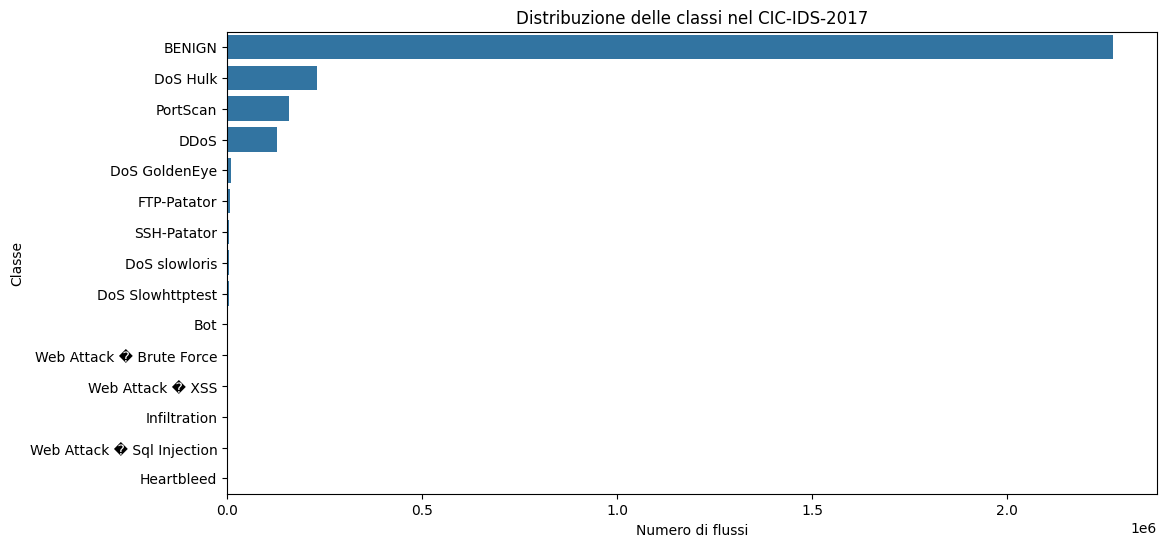

In [5]:
plt.figure(figsize=(12,6))
sns.countplot(
    y=data["Label"],
    order=data["Label"].value_counts().index
)
plt.title("Distribuzione delle classi nel CIC-IDS-2017")
plt.xlabel("Numero di flussi")
plt.ylabel("Classe")
plt.show()

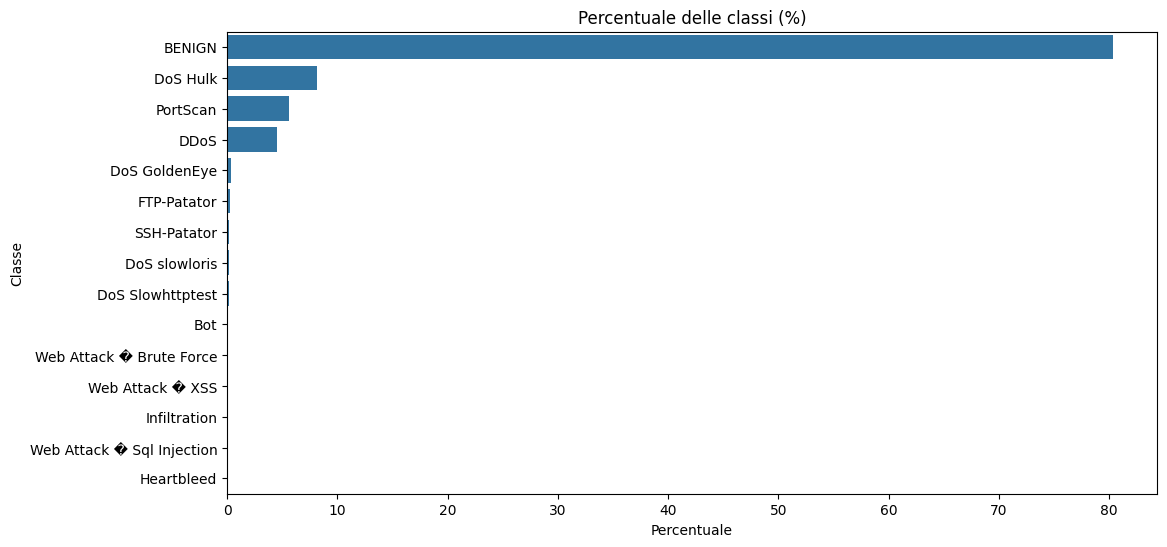

In [6]:
label_percent = data["Label"].value_counts(normalize=True) * 100

plt.figure(figsize=(12,6))
sns.barplot(
    x=label_percent.values,
    y=label_percent.index
)
plt.title("Percentuale delle classi (%)")
plt.xlabel("Percentuale")
plt.ylabel("Classe")
plt.show()

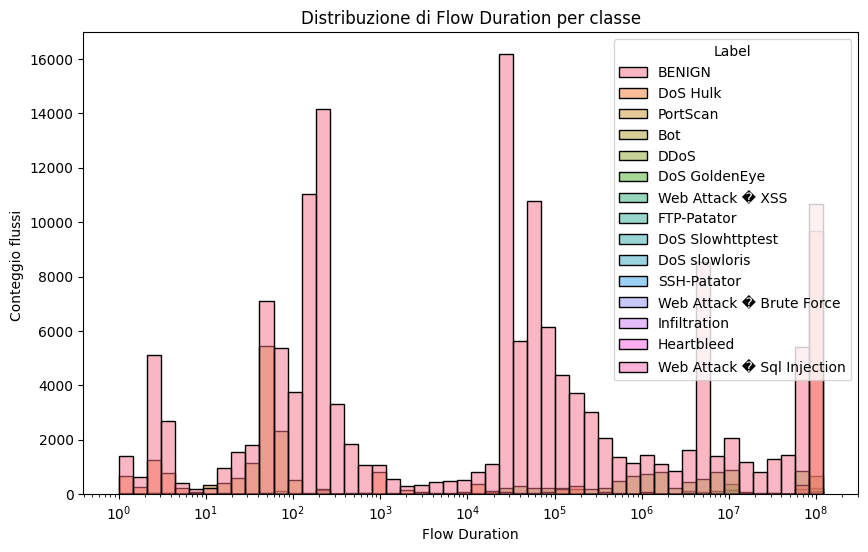

In [7]:
sample = data.sample(200_000, random_state=42)

plt.figure(figsize=(10,6))
sns.histplot(
    data=sample,
    x="Flow Duration",
    hue="Label",
    bins=50,
    kde=False,
    log_scale=True
)
plt.title("Distribuzione di Flow Duration per classe")
plt.ylabel("Conteggio flussi ")
plt.show()

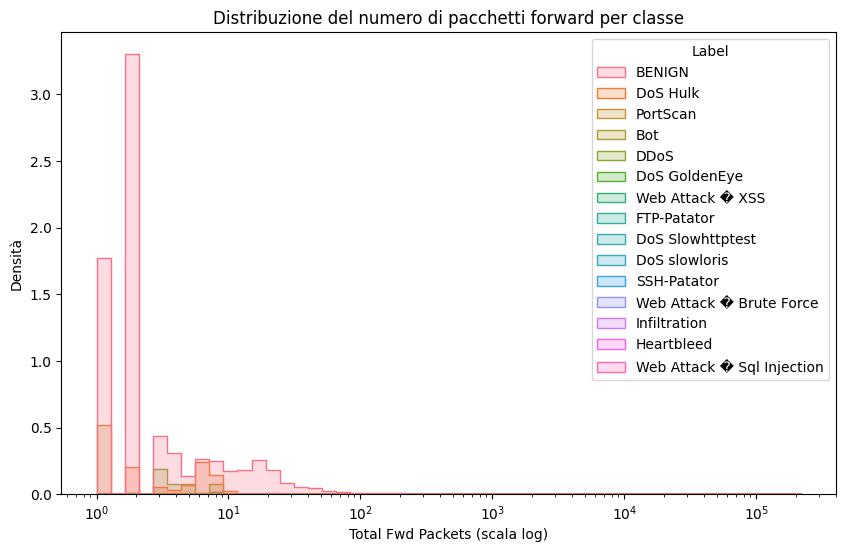

In [8]:
sample = data.sample(200_000, random_state=42)

plt.figure(figsize=(10,6))
sns.histplot(
    data=sample,
    x="Total Fwd Packets",
    hue="Label",
    bins=50,
    log_scale=True,
    element="step",
    stat="density"
)

plt.title("Distribuzione del numero di pacchetti forward per classe")
plt.xlabel("Total Fwd Packets (scala log)")
plt.ylabel("Densità")
plt.show()

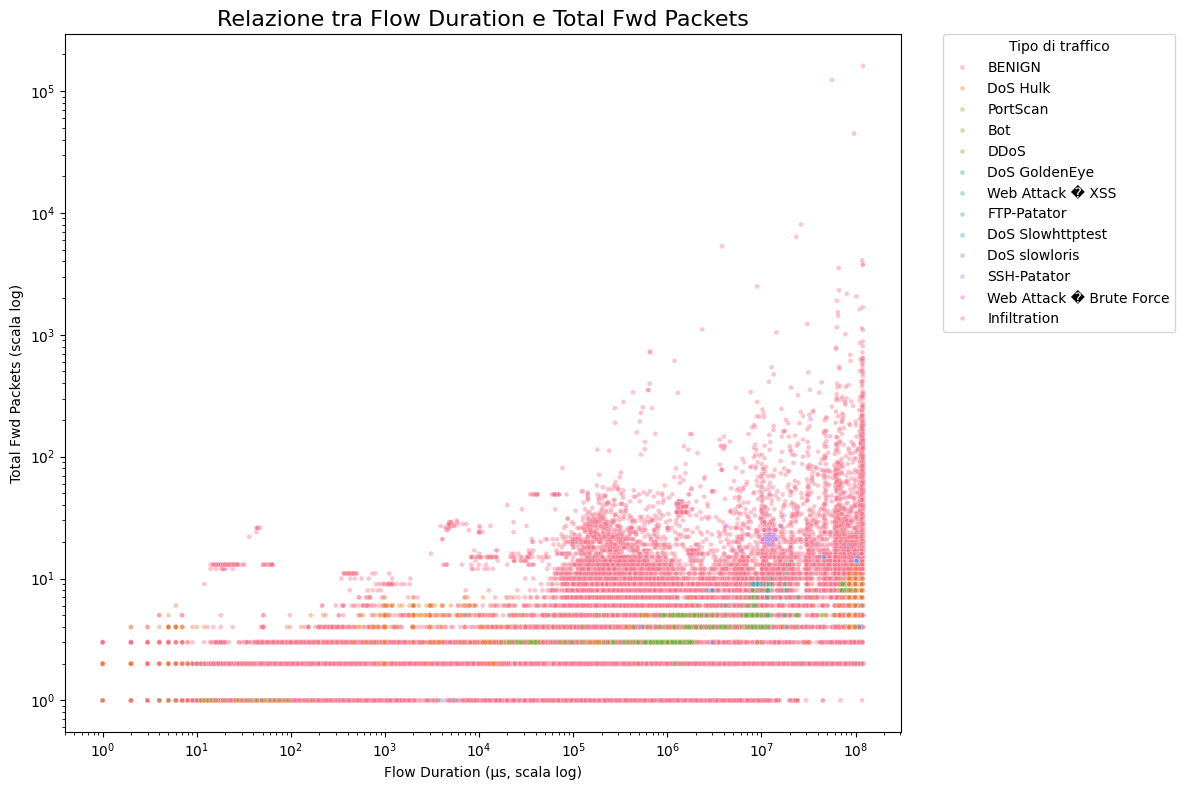

In [9]:
sample = data.sample(100_000, random_state=42)

plt.figure(figsize=(12,8))
ax = sns.scatterplot(
    data=sample,
    x="Flow Duration",
    y="Total Fwd Packets",
    hue="Label",
    alpha=0.4,
    s=12
)

ax.set_xscale("log")
ax.set_yscale("log")

plt.title("Relazione tra Flow Duration e Total Fwd Packets", fontsize=16)
plt.xlabel("Flow Duration (µs, scala log)")
plt.ylabel("Total Fwd Packets (scala log)")

# legenda spostata fuori
plt.legend(
    title="Tipo di traffico",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.
)

plt.tight_layout()
plt.show()

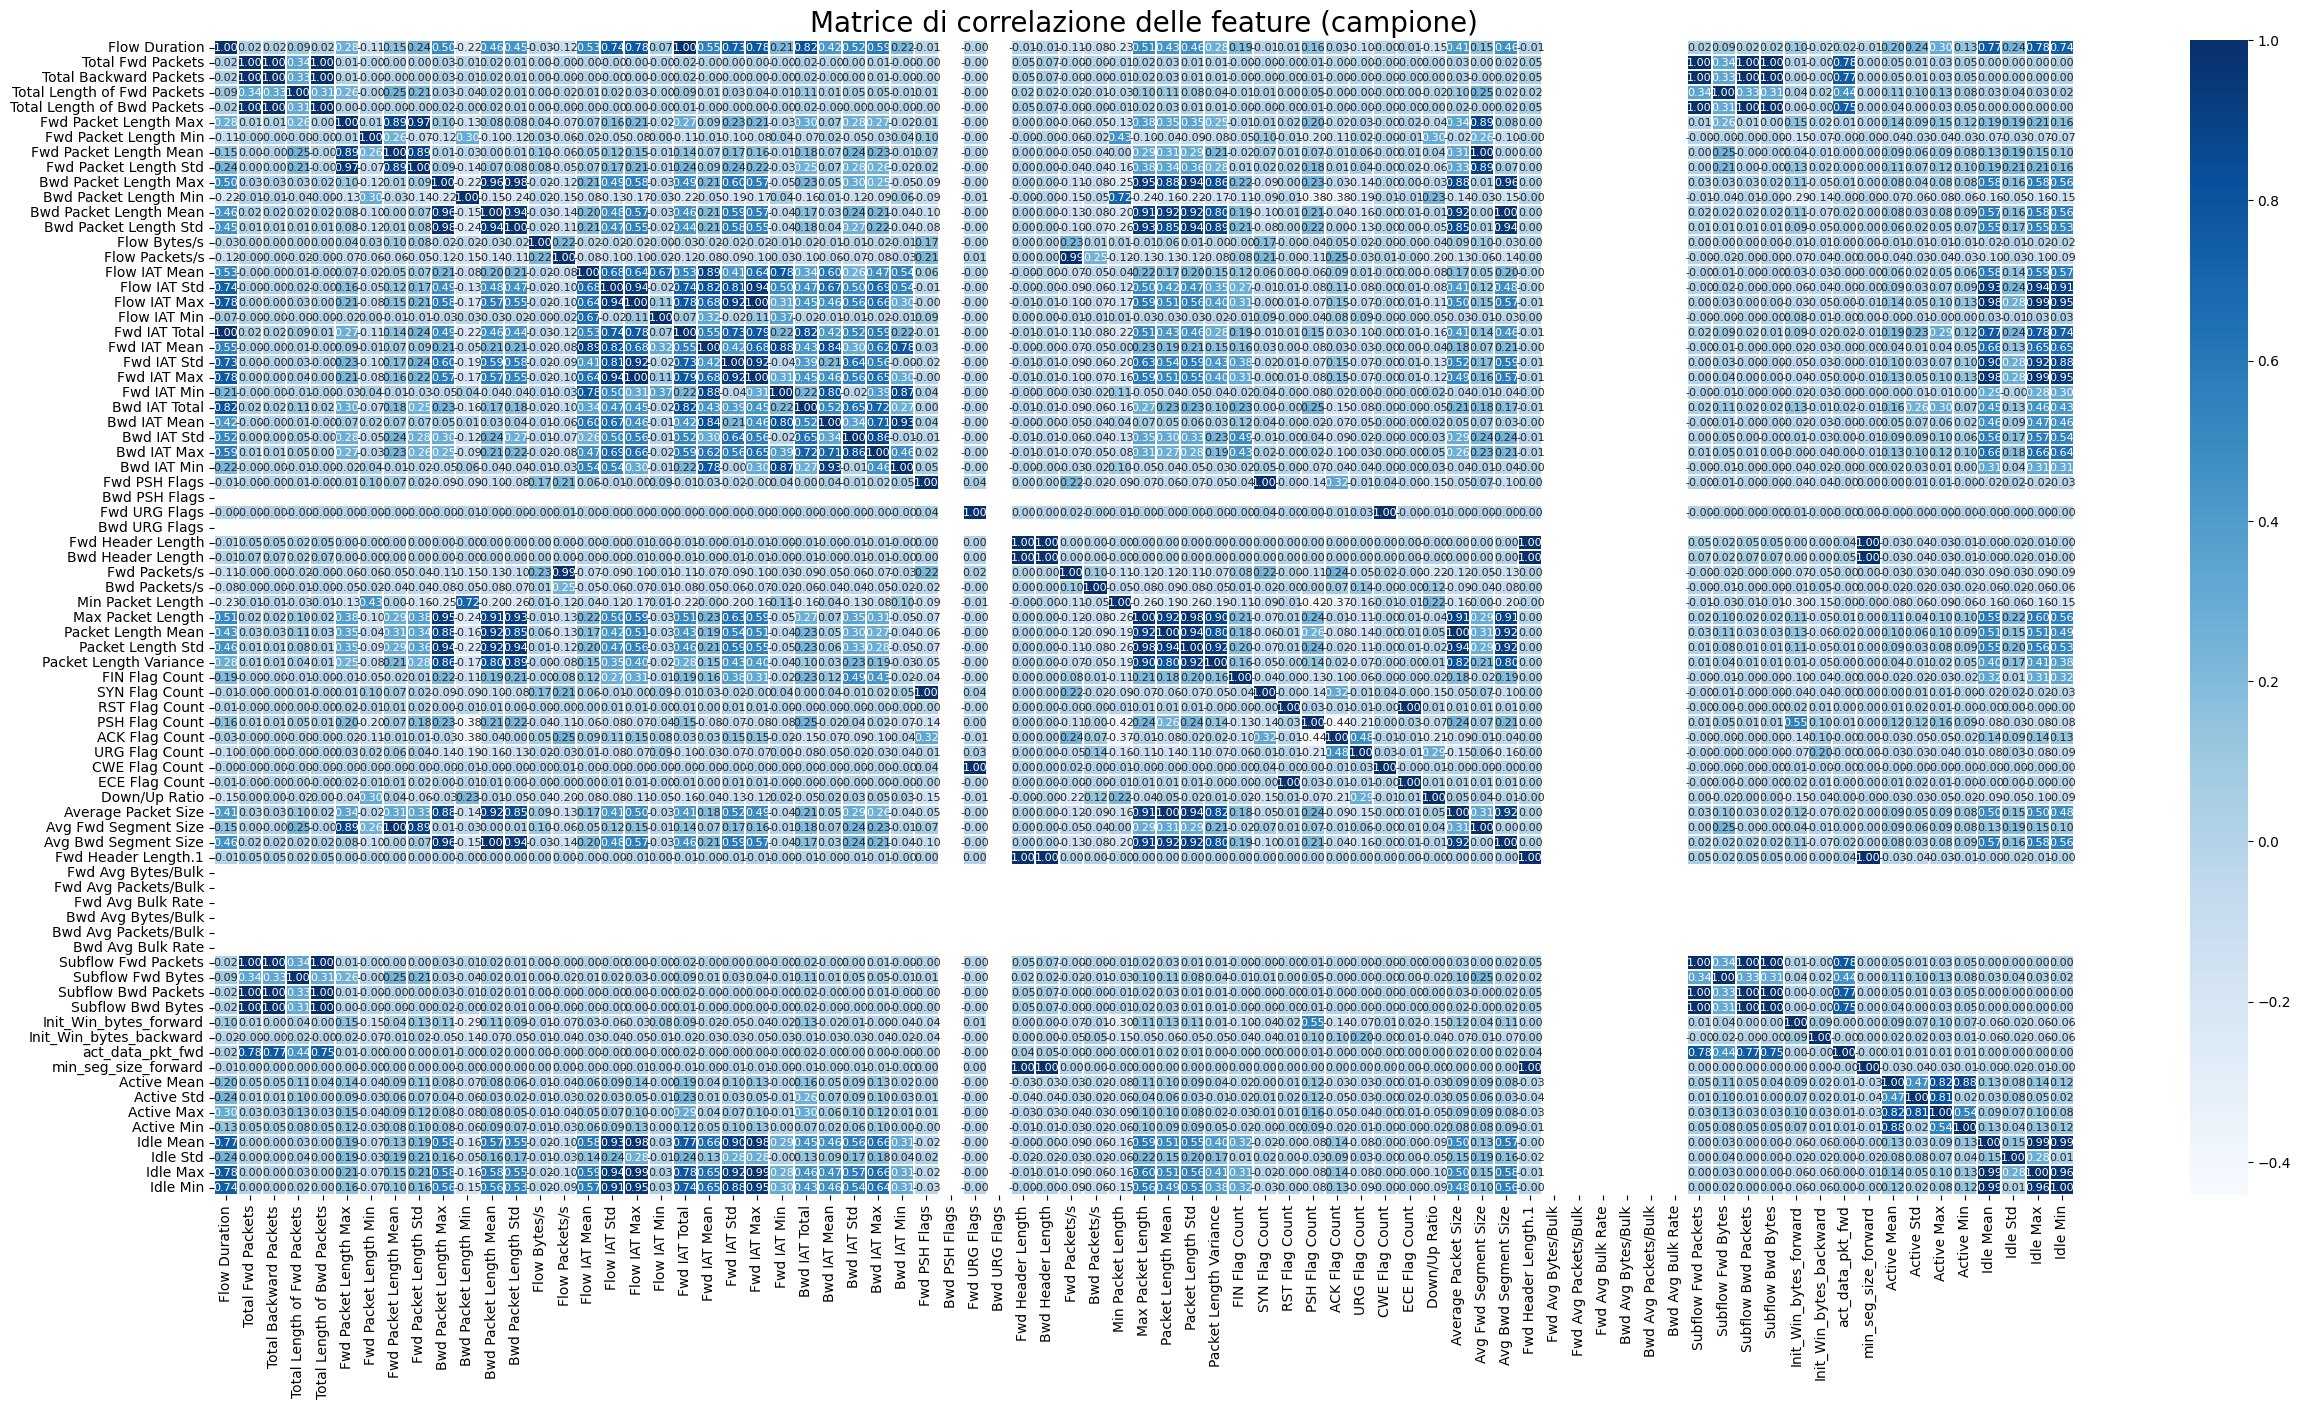

In [10]:
# Campionamento per rendere il calcolo sostenibile
sample = data.sample(100_000, random_state=42)

# Calcolo matrice di correlazione (solo feature numeriche)
corr_matrix = sample.drop(columns=["Label"]).corr()

plt.figure(figsize=(30, 15))
ax = sns.heatmap(
    corr_matrix,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8},
    linewidths=0.3
)

plt.title("Matrice di correlazione delle feature (campione)", fontsize=20)
plt.show()

Preprocessing

In [11]:
X = data.drop(columns=["Label"])
y = data["Label"]

print(y.value_counts())

Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_enc = le.fit_transform(y)

# Mappatura classi (da salvare!)
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
label_mapping

{'BENIGN': np.int64(0),
 'Bot': np.int64(1),
 'DDoS': np.int64(2),
 'DoS GoldenEye': np.int64(3),
 'DoS Hulk': np.int64(4),
 'DoS Slowhttptest': np.int64(5),
 'DoS slowloris': np.int64(6),
 'FTP-Patator': np.int64(7),
 'Heartbleed': np.int64(8),
 'Infiltration': np.int64(9),
 'PortScan': np.int64(10),
 'SSH-Patator': np.int64(11),
 'Web Attack � Brute Force': np.int64(12),
 'Web Attack � Sql Injection': np.int64(13),
 'Web Attack � XSS': np.int64(14)}

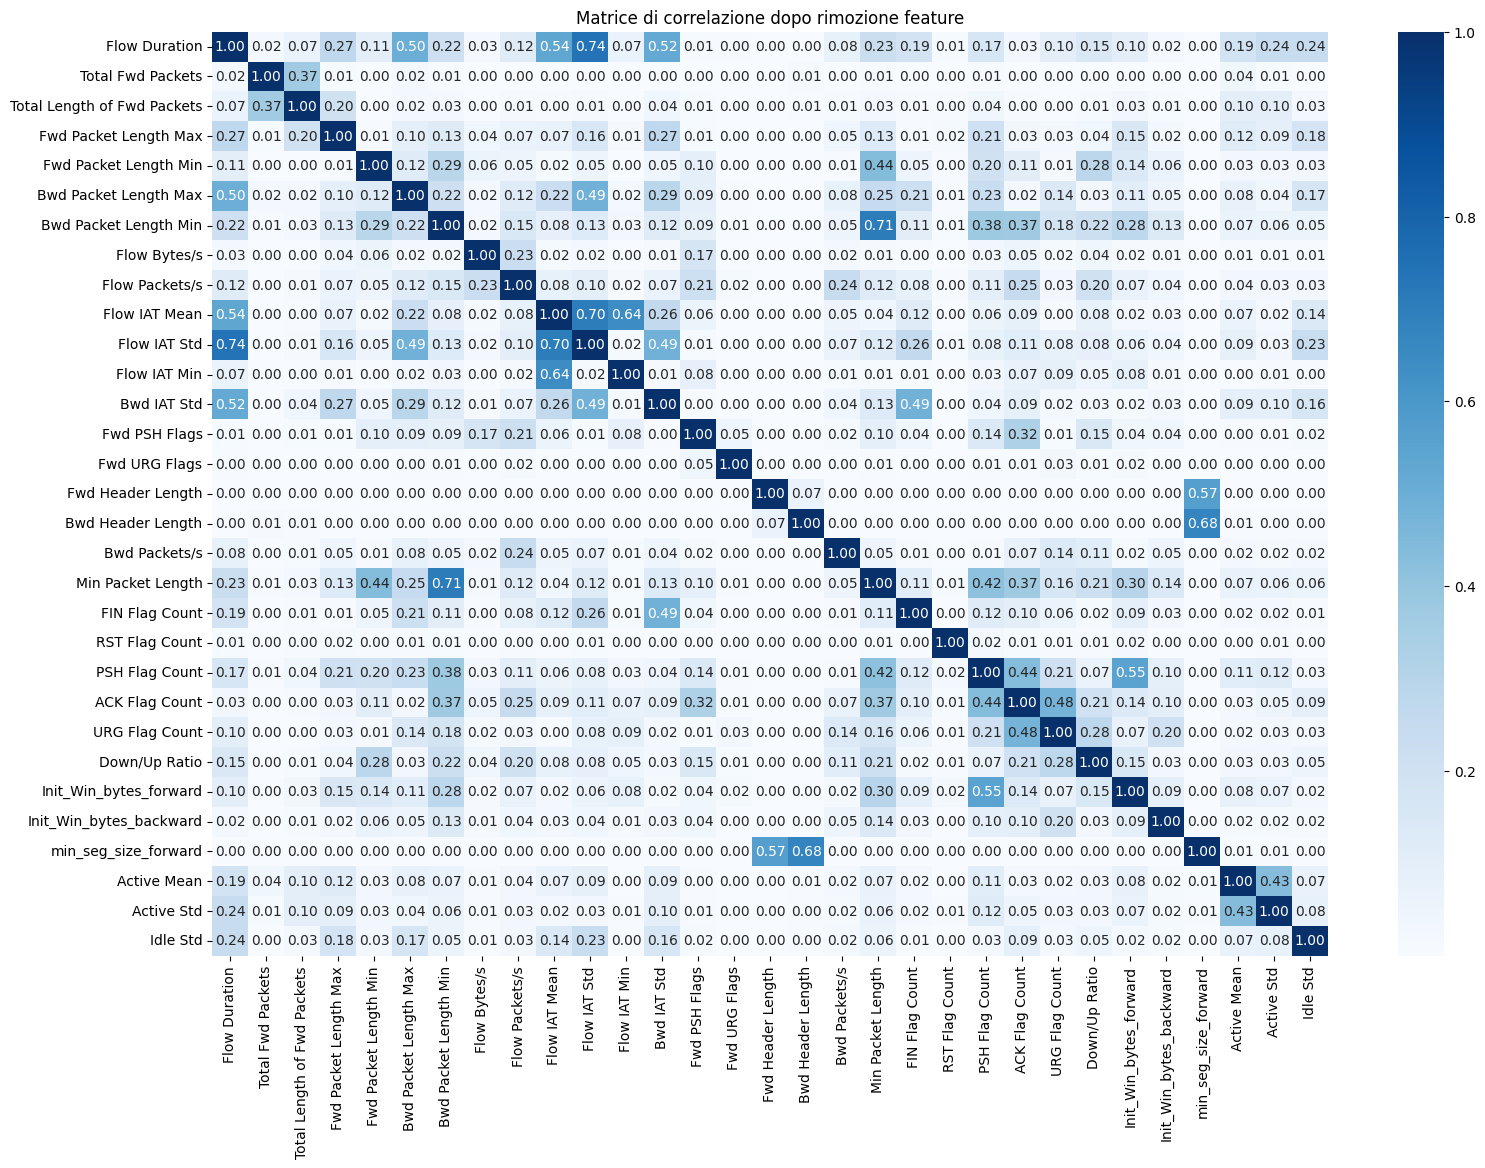

In [18]:
corr_matrix = X.corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop = [
    column for column in upper.columns
    if any(upper[column] > 0.8)
]

to_drop
X_red = X.drop(columns=to_drop)
#Rimozione delle feature a varianza zero
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=0.0)
X_final_array = vt.fit_transform(X_red)

kept_cols = X_red.columns[vt.get_support()]
dropped_zero_var = X_red.columns[~vt.get_support()]

X_final = pd.DataFrame(X_final_array, columns=kept_cols, index=X_red.index)

#Ricalocolo la matrice di correlazione senza le feature eliminate
corr_matrix_final = X_final.corr().abs()

plt.figure(figsize=(18, 12))
sns.heatmap(
    corr_matrix_final,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10}
)
plt.title("Matrice di correlazione dopo rimozione feature")
plt.show()
